<a href="https://colab.research.google.com/github/shiling2007/Python-/blob/main/python_control_car_changing_lanes%2Bparking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/Lease Payment Formula.ipynb') 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 999)
pd.set_option("max_colwidth", 500)
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')
%load_ext autoreload
%autoreload 2

In [2]:
!pip install slycot 
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1418337 sha256=49f149b4353afd4c3c164e86b87c00f15f9b482af79ff158c3a141e49c456889
  Stored in directory: /root/.cache/pip/wheels/fa/b2/19/1e6568896fbabaf2a03d2fb6575211d281afcb9e00ce026cf6
Successfully built slycot
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 357 kB 4.0 MB/s 
  Created wheel for control: filename=control-0.9.1-py2.py3-none-any.whl size=364703 sha256=a12154302849b2800acfabca61d0cecc9a0b41f68f42d2c447757380706deb11
  Stored in directory: /root/.cache/pip/wheels/b1/50/22/8005107713828997d1af664fbd629c7f935a1b87fc2f4ba6c1
Su

In [3]:
import control as ct
print(ct.__version__)
#the version should match

0.9.1


In [4]:
# kincar-flatsys.py - differentially flat systems example
# RMM, 3 Jul 2019
#
# This example demonstrates the use of the `flatsys` module for generating
# trajectories for differnetially flat systems by computing a trajectory for a
# kinematic (bicycle) model of a car changing lanes.

import os
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.flatsys as fs
import control.optimal as opt


In [5]:
#
# System model and utility functions
# input - output or diffirential system

# Function to take states, inputs and return the flat flag
def vehicle_flat_forward(x, u, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a list of arrays to store the flat output and its derivatives
    zflag = [np.zeros(3), np.zeros(3)]

    # Flat output is the x, y position of the rear wheels
    zflag[0][0] = x[0]
    zflag[1][0] = x[1]

    # First derivatives of the flat output
    zflag[0][1] = u[0] * np.cos(x[2])  # dx/dt
    zflag[1][1] = u[0] * np.sin(x[2])  # dy/dt

    # First derivative of the angle
    thdot = (u[0]/b) * np.tan(u[1])

    # Second derivatives of the flat output (setting vdot = 0)
    zflag[0][2] = -u[0] * thdot * np.sin(x[2])
    zflag[1][2] =  u[0] * thdot * np.cos(x[2])

    return zflag

In [6]:
# Function to take the flat flag and return states, inputs
# flat system to state space equation
def vehicle_flat_reverse(zflag, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a vector to store the state and inputs
    x = np.zeros(3)
    u = np.zeros(2)

    # Given the flat variables, solve for the state
    x[0] = zflag[0][0]  # x position
    x[1] = zflag[1][0]  # y position
    x[2] = np.arctan2(zflag[1][1], zflag[0][1])  # tan(theta) = ydot/xdot

    # And next solve for the inputs
    u[0] = zflag[0][1] * np.cos(x[2]) + zflag[1][1] * np.sin(x[2])
    thdot_v = zflag[1][2] * np.cos(x[2]) - zflag[0][2] * np.sin(x[2])
    u[1] = np.arctan2(thdot_v, u[0]**2 / b)

    return x, u

# Function to compute the RHS of the system dynamics
def vehicle_update(t, x, u, params):
    b = params.get('wheelbase', 3.)             # get parameter values
    dx = np.array([
        np.cos(x[2]) * u[0],
        np.sin(x[2]) * u[0],
        (u[0]/b) * np.tan(u[1])
    ])
    return dx

In [8]:
# np.arctan(0.5), np.arctan2(1,2)

(0.4636476090008061, 0.4636476090008061)

In [13]:
# Create differentially flat input/output system for lane change problem
vehicle_flat = fs.FlatSystem(
    vehicle_flat_forward, vehicle_flat_reverse, vehicle_update,
    inputs=('v', 'delta'), outputs=('x', 'y', 'theta'),
    states=('x', 'y', 'theta'))

# Define the endpoints  of the trajectory 
# lane change problem start-end point and duration time 
x0 = [0., -2., 0.]; u0 = [10., 0.]
xf = [40., 2., 0.]; uf = [10., 0.]
Tf = 4

In [14]:
# Define a set of basis functions to use for the trajectories
poly = fs.PolyFamily(6)

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(vehicle_flat, Tf, x0, u0, xf, uf, basis=poly)

In [15]:
# Create the desired trajectory between the initial and final condition
T = np.linspace(0, Tf, 100)
xd, ud = traj.eval(T)

In [16]:
traj.coeffs

[array([-2.4071e-14, 10, 3.8025e-15, -6.2617e-14, 1.7764e-15, 1.7764e-15]),
 array([-2, -5.4349e-15, -2.3176e-15, 0.625, -0.23438, 0.023438])]

In [17]:
xd.shape, ud.shape, T.shape

((3, 100), (2, 100), (100,))

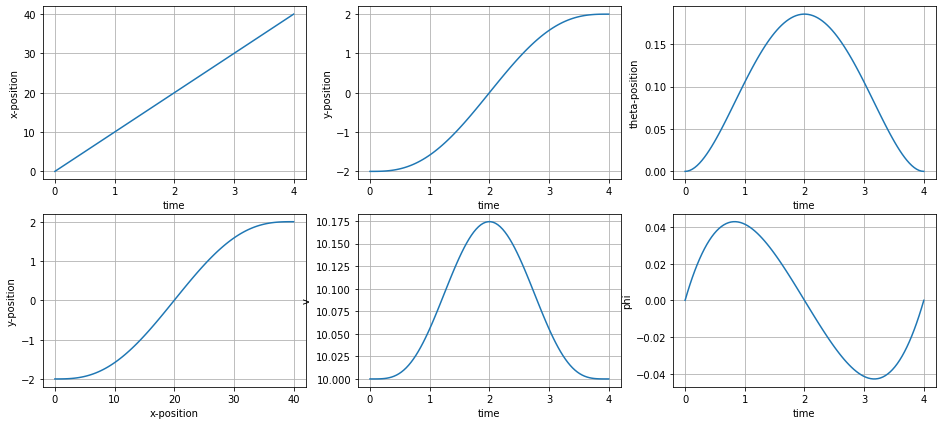

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,7))
ax1.plot(T, xd[0,:])
ax1.set_xlabel('time')
ax1.set_ylabel('x-position')
ax1.grid()

ax2.plot(T, xd[1,:])
ax2.set_xlabel('time')
ax2.set_ylabel('y-position')
ax2.grid()

ax3.plot(T, xd[2,:])
ax3.set_xlabel('time')
ax3.set_ylabel('theta-position')
ax3.grid()

ax4.plot(xd[0,:], xd[1,:])
ax4.set_xlabel('x-position')
ax4.set_ylabel('y-position')
ax4.grid()

ax5.plot(T, ud[0,:])
ax5.set_xlabel('time')
ax5.set_ylabel('v')
ax5.grid()

ax6.plot(T, ud[1,:])
ax6.set_xlabel('time')
ax6.set_ylabel('phi')
ax6.grid()


In [19]:
# Define timepoints for evaluation plus basis function to use
timepts = np.linspace(0, Tf, 10)

# basis = fs.PolyFamily(5)
# basis = fs.PolyFamily(6)
# basis = fs.PolyFamily(7)
basis = fs.PolyFamily(8)
# basis = fs.PolyFamily(9)
# basis = fs.PolyFamily(10)
# basis = fs.PolyFamily(11)


# Define the cost function (penalize lateral error and steering)
traj_cost = opt.quadratic_cost(
    vehicle_flat, np.diag([0, 0.1, 0]), np.diag([0.1, 1]), x0=xf, u0=uf)

# Solve for an optimal solution
traj = fs.point_to_point(
    vehicle_flat, timepts, x0, u0, xf, uf, cost=traj_cost, basis=basis,
)
xd, ud = traj.eval(T)

In [20]:
xd.shape, ud.shape

((3, 100), (2, 100))

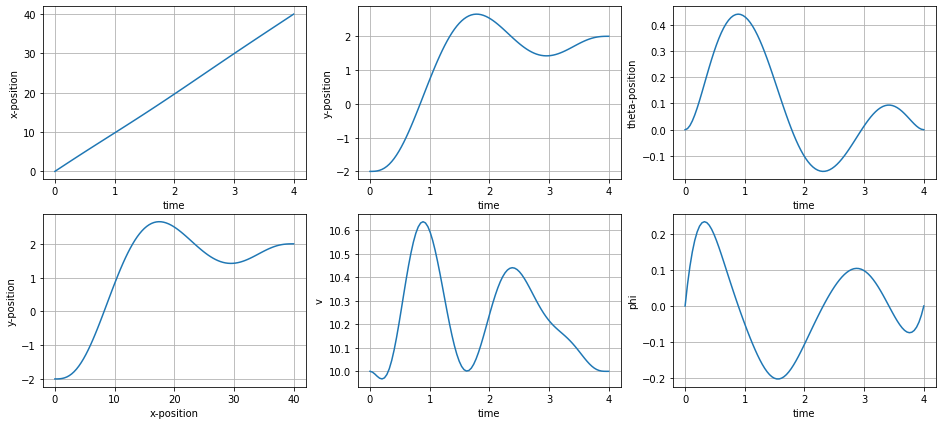

In [21]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,7))
ax1.plot(T, xd[0,:])
ax1.set_xlabel('time')
ax1.set_ylabel('x-position')
ax1.grid()

ax2.plot(T, xd[1,:])
ax2.set_xlabel('time')
ax2.set_ylabel('y-position')
ax2.grid()

ax3.plot(T, xd[2,:])
ax3.set_xlabel('time')
ax3.set_ylabel('theta-position')
ax3.grid()

ax4.plot(xd[0,:], xd[1,:])
ax4.set_xlabel('x-position')
ax4.set_ylabel('y-position')
ax4.grid()

ax5.plot(T, ud[0,:])
ax5.set_xlabel('time')
ax5.set_ylabel('v')
ax5.grid()

ax6.plot(T, ud[1,:])
ax6.set_xlabel('time')
ax6.set_ylabel('phi')
ax6.grid()

In [22]:
# Create differentially flat input/output system for parking problem(1)
vehicle_flat = fs.FlatSystem(
    vehicle_flat_forward, vehicle_flat_reverse, vehicle_update,
    inputs=('v', 'delta'), outputs=('x', 'y', 'theta'),
    states=('x', 'y', 'theta'))

# Define the endpoints  of the trajectory 
# lane change problem start-end point and duration time 
x0 = [0., 4., 0.]; u0 = [0., 0.]
xf = [8., 2., 0.]; uf = [0., 0.]
Tf = 4

In [23]:
# Define a set of basis functions to use for the trajectories
poly = fs.PolyFamily(6)

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(vehicle_flat, Tf, x0, u0, xf, uf, basis=poly)

In [24]:
# Create the desired trajectory between the initial and final condition
T = np.linspace(0, Tf, 100)
xd, ud = traj.eval(T)

In [25]:
traj.coeffs

[array([-2.579e-15, -8.1298e-15, 1.4369e-15, 1.25, -0.46875, 0.046875]),
 array([4, 1.6553e-14, 4.2605e-15, -0.3125, 0.11719, -0.011719])]

In [26]:
xd.shape, ud.shape, T.shape

((3, 100), (2, 100), (100,))

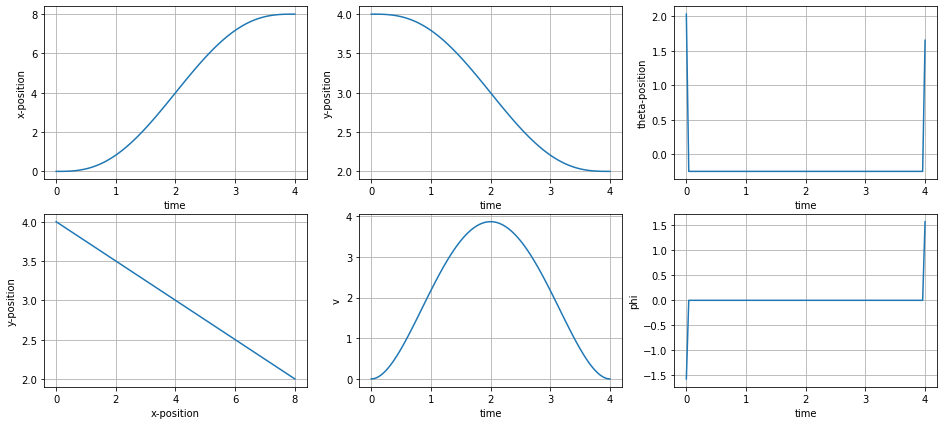

In [27]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,7))
ax1.plot(T, xd[0,:])
ax1.set_xlabel('time')
ax1.set_ylabel('x-position')
ax1.grid()

ax2.plot(T, xd[1,:])
ax2.set_xlabel('time')
ax2.set_ylabel('y-position')
ax2.grid()

ax3.plot(T, xd[2,:])
ax3.set_xlabel('time')
ax3.set_ylabel('theta-position')
ax3.grid()

ax4.plot(xd[0,:], xd[1,:])
ax4.set_xlabel('x-position')
ax4.set_ylabel('y-position')
ax4.grid()

ax5.plot(T, ud[0,:])
ax5.set_xlabel('time')
ax5.set_ylabel('v')
ax5.grid()

ax6.plot(T, ud[1,:])
ax6.set_xlabel('time')
ax6.set_ylabel('phi')
ax6.grid()